# Giriş

Bu veri seti, İzmir Ekonomi Üniversitesi'nde **9** farklı deniz ürünü türüne ait segmentasyon ve **sınıflandırma** çalışmaları için toplanmıştır. Her bir tür için **1000** adet **RGB** görüntü ve bu görüntülerin karşılık gelen 1000 adet ground truth (gerçek etiket) görüntüsü bulunur. Görüntüler, iki farklı kamera ile toplanmış ve boyutları **590x445** olacak şekilde yeniden boyutlandırılmıştır. Veri seti, özellik çıkarımı, segmentasyon ve sınıflandırma algoritmalarını test etmek ve karşılaştırmak amacıyla kullanılmıştır. Biz ise sınıflandırma için kullanacağız. bir sınıf için görüntüler sıralıdır ve "00000.png" ile "01000.png" arasında adlandırılmıştır.

Şimdi ise hiperparametreler üzerinden belli başlı işlemler yapılacak.
1. 128 ve 512 gizli katmanlı modeller kıyaslanacak.
2. Dropout değeri "0.5" ve "0.7" yapılıp kıyaslanacak
3. Optimizasyon olarak hali hazırda kullanılan **Adam** algoritması **SGD** ile kıyaslanacak 
4. (giriş_boyutu, 512, 128, kategori_sayısı-9- ) katmanlı model eğitilecek
5. En sonda ise eğitilen tüm modeller kıyaslanacak

İlk önce gerekli kütüphaneleri **içeri aktaralım**. (import)

## Kütüphaneleri İçe Aktarma

In [1]:
import os
import pandas as pd
from PIL import Image  # Görselleri okumak için gerekli kütüphane
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np

# Uyarıların gizlenmesi
import warnings
warnings.filterwarnings("ignore")

#Tüm sütunları görebilmek için tabloyu ayarladık.
pd.set_option('display.max_colwidth', 1000)

# Veri Setini ----> Pandas DataFrame

Bu kod, bir dosya sisteminde bulunan deniz mahsulleri görsellerinin dosya yollarını ve etiketlerini toplar ve bu verileri pandas kütüphanesinin DataFrame yapısına çevirir. DataFrame kullanmamızın sebebi, veriyi ön incelemede daha kolay ve rahat bir şekilde ele almamızı sağlamasıdır.


In [2]:
label = []                    #Deniz mahsülünün hangi etikette olduğunu belirten liste
path = []                     #Deniz mahsül görselinin adres yolu

fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Verileri klasörlerden toplayarak her tür için görselleri ve etiketleri alıyoruz
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':          # Görselleri sınıflandıracağımız için sadece .png dosyalarını alıyoruz
            if dir_name.split()[-1] != 'GT':                   # Seegmentasyon değil de sınıflandırma yaptığımız için ground truth etiketlerine ihtiyacımız yok.
                file_path = os.path.join(dir_name, filename)
                label.append(os.path.split(dir_name)[-1])  # Adres yolunun adından deniz mahsülünün etiketini elde ediyoruz.
                path.append(file_path)  # Dosya yolunu kaydediyoruz

# Etiket ve dosya yollarından bir DataFrame oluşturuyoruz
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

data.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00704.png,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00562.png,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00237.png,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00406.png,Hourse Mackerel


# Keşifsel Veri Analizi

Veri setindeki hangi deniz mahsülleri ve kaç tane var inceleyelim. 

* 9 tane kategori var ve her birinden bin tane örnek bulunmaktadır. 

In [3]:
data["label"].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

## Boş Değer Kontrolü

Bu kod parçası, path ve label sütunlarında eksik (boş) değer olup olmadığını analiz eder. Eksik değerler veri temizleme sürecinde önemli bir adımdır, çünkü makine öğrenmesi modelleri eksik veri içeren kayıtlarla doğru çalışamayabilir.

In [4]:
# "path" ve "label" sütunlarında eksik değerleri yazdırıyoruz
print(f"Boş path sayısı: {data['path'].isnull().sum()}")
print(f"Boş label sayısı: {data['label'].isnull().sum()}")

Boş path sayısı: 0
Boş label sayısı: 0


In [5]:
data.describe()

,path,label
count,9000,9000
unique,9000,9
top,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png,Hourse Mackerel
freq,1,1000


## Veri Setinin Görselleştirilmesi
Veri setindeki her bir kategoriden en az bir tane deniz mahsulü örneğini seçip görselleştirelim. İlk olarak, her kategoriden bir örnek alınır ve görselleri göstermek için 3x3'lük bir grid yapısı oluşturulur. Her görselin üzerinde, görselin kategorisini gösteren bir başlık bulunur. Bu işlem, veri setindeki her bir kategoriden en az bir tane deniz mahsulünü incelememizi sağlar.

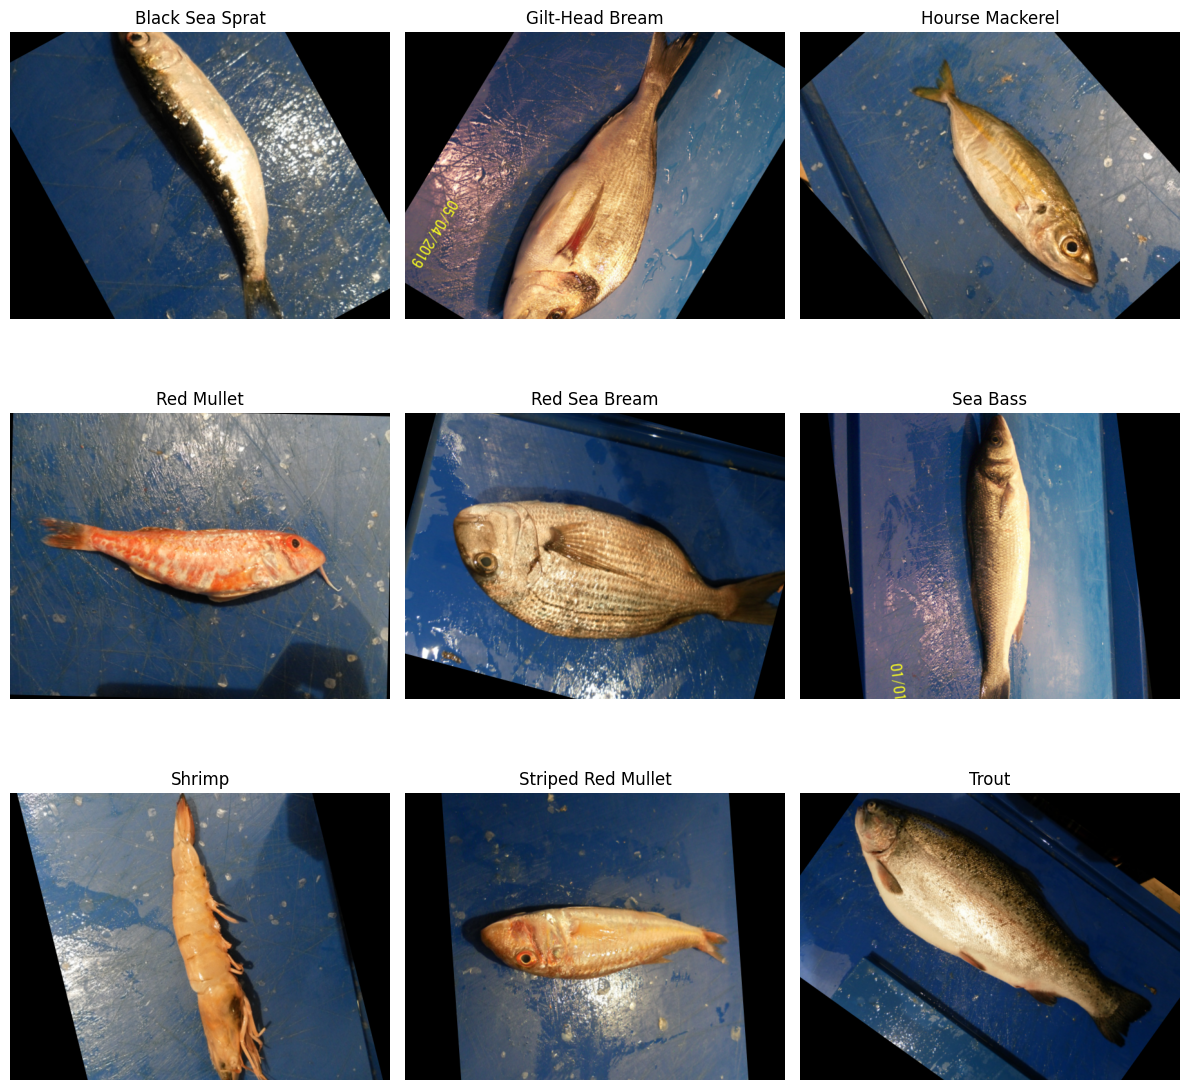

In [6]:
# Her kategoriden bir tane örnek seçiyoruz
sample_data = data.groupby('label').apply(lambda x: x.iloc[0]).reset_index(drop=True)

# Görselleri görselleştirmek için bir ızgara (grid) oluşturuyoruz
plt.figure(figsize=(12, 12))  # Grafik boyutunu ayarlıyoruz

for idx, row in sample_data.iterrows():
    # Görselleri açıyoruz
    img = Image.open(row['path'])
    
    # 3x3'lük bir grid yapısı oluşturuyoruz
    plt.subplot(3, 3, idx + 1)  # 3 satır, 3 sütun, sırayla her bir görsel
    plt.imshow(img)
    plt.axis('off')  # Eksenleri kapatıyoruz
    plt.title(row['label'])  # Başlık olarak etiketi ekliyoruz

plt.tight_layout()
plt.show()

## Frekansı Görselleştirme

Görselleştirme, veri setinin dengeli bir şekilde dağılmış olup olmadığını anlamak açısından önemlidir. "Veri seti dengeli bir şekilde dağılmış" ifadesi, tüm sınıfların eşit veya yakın sayılarda örneklere sahip olduğunu gösterir, bu da sınıflandırma modelleri için önemlidir çünkü dengesiz bir veri seti modelin bazı sınıflarda kötü performans göstermesine yol açabilir.

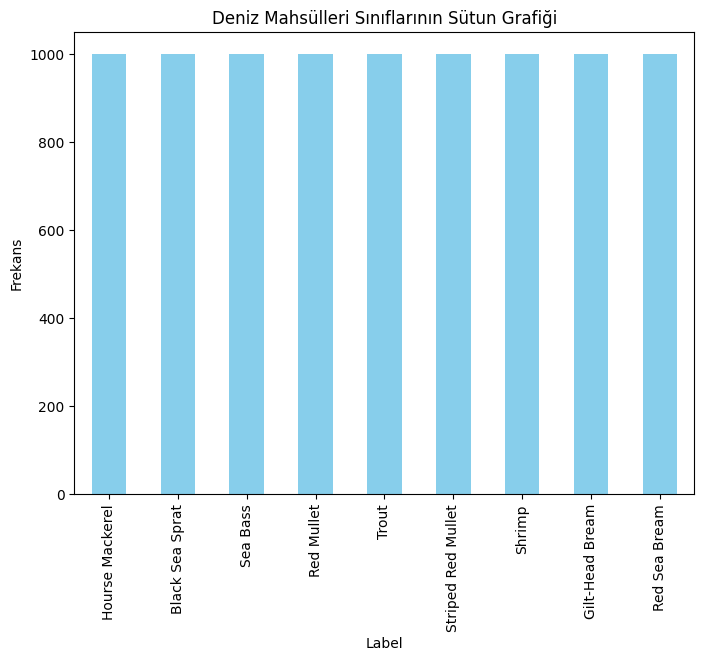

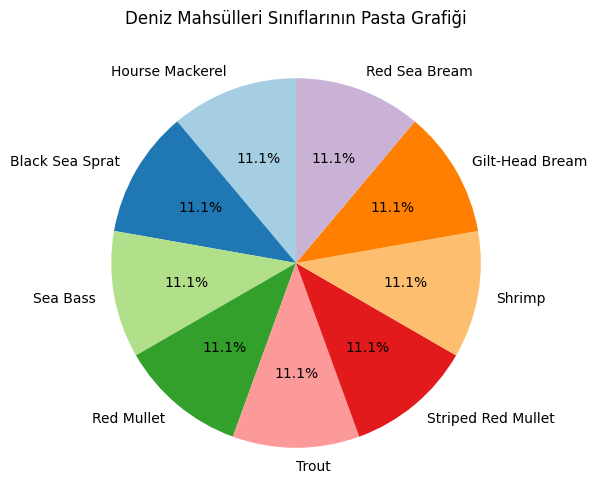

In [7]:
# Frekansları saymak için:
label_counts = data["label"].value_counts()

# 1. Sütun Grafiği (Bar Plot)
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Deniz Mahsülleri Sınıflarının Sütun Grafiği')
plt.xlabel('Label')
plt.ylabel('Frekans')
plt.show()

# 2. Pasta Grafiği (Pie Chart)
plt.figure(figsize=(8, 6))
label_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Deniz Mahsülleri Sınıflarının Pasta Grafiği')
plt.ylabel('')  # Y eksenini kaldırıyoruz
plt.show()

# Veri Setini Ayırma

Modelimizin örüntüleri öğrenebilmesi için, veri setini eğitim, doğrulama ve test kümelerine her bir kategoriden eşit sayıda örnek olacak şekilde bölmemiz gerekiyor. Bunu yaparken:

1. Eğitim, doğrulama ve test kümeleri, sırasıyla 8:1:1 oranında ayrılacak.
2. Veri seti karıştırılacak (shuffle) ve böylece dağılımın rastgele olmasını sağlayacağız.
3. Bu oranları dikkate alarak, her bir deniz mahsulü kategorisini eğitim, doğrulama ve test kümelerine ayıracağız.

Kodda **shuffle** fonksiyonu, verilerin karışmasını sağlayarak modelin öğrenme sırasında veri sıralamasından etkilenmesini önler

In [8]:
train_ratio, validation_ratio, test_ratio = 0.8 , 0.1 , 0.1

# Shuffle edilen DataFrame
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Boş bir 'split' sütunu oluşturuyoruz
shuffled_data['split'] = np.nan

# Kategoriler üzerinde döngü
for category in shuffled_data['label'].unique():
    # Her kategoriye ait verileri seçiyoruz
    category_data = shuffled_data[shuffled_data['label'] == category]
    
    # Kategoriyi shuffle ediyoruz
    category_data = category_data.sample(frac=1, random_state=42)
    
    # Her kategori için oranlara göre ayırıyoruz (%70 train, %15 val, %15 test)
    train_size = int(train_ratio * len(category_data))
    val_size = int(validation_ratio * len(category_data))
    
    # Kategorinin ilk %70'ini 'train', sonraki %15'ini 'val', kalanını 'test' olarak etiketliyoruz
    shuffled_data.loc[category_data.index[:train_size], 'split'] = 'train'
    shuffled_data.loc[category_data.index[train_size:train_size + val_size], 'split'] = 'val'
    shuffled_data.loc[category_data.index[train_size + val_size:], 'split'] = 'test'

# Boş kalan satırları kontrol ediyoruz
empty_rows = shuffled_data[shuffled_data['split'].isna()]
print(f"Boş kalan satır sayısı: {len(empty_rows)}")

# Sonuçları inceleyelim
print(shuffled_data['split'].value_counts())  # Kaç tane train, val, test var görelim
print(shuffled_data.head())  # İlk birkaç satırı kontrol edelim

Boş kalan satır sayısı: 0
split
train    7200
test      900
val       900
Name: count, dtype: int64
                                                                                                           path  \
0  /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream/00431.png   
1  /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00131.png   
2  /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00381.png   
3                      /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/00478.png   
4      /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/00761.png   

             label  split  
0  Gilt-Head Bream  train  
1  Black Sea Sprat  train  
2  Hourse Mackerel  train  
3            Trout  train  
4    Red Sea Bream  train  


# CustomDataset Sınıfı

* Bu kod parçası, PyTorch'un veri işleme altyapısında kullanılan **Dataset** sınıfından türetilen CustomDataset sınıfını tanımlar ve görsellerin dosya yollarını ve etiketlerini alarak gerektiğinde veri dönüşümleri uygulamayı sağlar. 
* Bu sınıf, üç temel yöntem olan __init__, __len__ ve __getitem__ fonksiyonları ile veri setine esnek ve kolay erişim sunar.
* **Transform** parametresi, her veri noktasına özel dönüşüm uygulamayı sağlayarak boyutlandırma, normalize etme gibi veri ön işleme işlemlerini kolaylaştırır. Bu yapı, çeşitli veri setlerini (örneğin görseller) işlemek için esneklik sunar
*  Veri yükleme sırasında modelin ihtiyaç duyduğu her bir veri örneğine __getitem__ fonksiyonu aracılığıyla erişim sağlar.

In [9]:
# Custom Dataset Sınıfı
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths  # Görsel dosya yolları
        self.labels = labels          # Etiketler
        self.transform = transform    # Dönüştürme işlemleri

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]  # Görsel dosya yolu
        label = self.labels[idx]         # Etiket
        
        # Görseli açıyoruz
        image = Image.open(img_path).convert("RGB")
        
        # Transform işlemi uygulanırsa
        if self.transform:
            image = self.transform(image)
        
        return image, label

# One Hot Encoding

* Makine öğrenmesi modelleri, kategorik verilerle doğrudan çalışamadığından, bu tür verilerin sayısal formatlara dönüştürülmesi gerekir.
*  **pd.factorize()** kullanarak etiketleri sayısallaştırmak, modelin bu verilerle işlemler yapmasına olanak tanır ve böylece sınıflandırma problemlerinde verinin işlenmesi daha kolay hale gelir. 

* Bu yöntem aynı zamanda verinin kolayca geri dönüştürülebilir (sayısal etiketten orijinal etikete) olmasını sağlar.

In [10]:
shuffled_data['label_encoded'], label_mapping = pd.factorize(shuffled_data['label'])

In [11]:
shuffled_data.head(), label_mapping

(                                                                                                           path  \
 0  /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream/00431.png   
 1  /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00131.png   
 2  /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00381.png   
 3                      /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/00478.png   
 4      /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/00761.png   
 
              label  split  label_encoded  
 0  Gilt-Head Bream  train              0  
 1  Black Sea Sprat  train              1  
 2  Hourse Mackerel  train              2  
 3            Trout  train              3  
 4    Red Sea Bream  train              4  ,
 Index(['Gilt-Head Bream', 'Black Sea

# DataFrame ---> List

Bu kod parçası, DataFrame yapısında bulunan train, validation ve test kümelerine ait dosya yolları ve etiketleri, iteratif işlemler yapabilmek için liste formatına dönüştürür.

In [12]:
# Train, Validation ve Test dosya yolları ve etiketlerini DataFrame'den çekiyoruz
train_file_paths = shuffled_data[shuffled_data['split'] == 'train']['path'].tolist()
train_labels = shuffled_data[shuffled_data['split'] == 'train']['label_encoded'].tolist()

val_file_paths = shuffled_data[shuffled_data['split'] == 'val']['path'].tolist()
val_labels = shuffled_data[shuffled_data['split'] == 'val']['label_encoded'].tolist()

test_file_paths = shuffled_data[shuffled_data['split'] == 'test']['path'].tolist()
test_labels = shuffled_data[shuffled_data['split'] == 'test']['label_encoded'].tolist()

# Hiperparametreler

Bu hiperparametreler, görüntü sınıflandırma problemine uygun olarak ayarlanmıştır. 
* **input_size** 64x64 piksel boyutundaki RGB resimlerden gelen 12,288 giriş biriminden oluşur, bu boyut hem modelin hızlı çalışmasını sağlar hem de yeterli detay sunar. 
* **output_size**, veri setindeki 9 farklı deniz mahsulü sınıfını temsil eder ve modelin bu sınıflardan birini tahmin etmesi beklenir.
* **epochs** ise modelin eğitim sürecinde veri seti üzerinde 15 kez geçiş yapacağını ifade eder, bu sayede model yeterli öğrenmeyi sağlayacak şekilde eğitilir.

In [13]:
input_size = 64 * 64 * 3  # 64x64 boyutunda ve 3 kanallı (RGB) bir resim
output_size = 9  # 9 sınıflı bir sınıflandırma problemi
epochs = 15

# CustomDataset Nesneleri

Bu kod parçasında, tüm görsellerin boyutu önce 590x445 olarak normalize edilmiştir, ancak yeterli donanım kaynağı olmadığı için işlem gücünü optimize etmek amacıyla boyut 64x64 olarak ayarlanmıştır. Görsellerin yeniden boyutlandırılması transforms.Resize((64, 64)) ile yapılır, ardından görseller ToTensor() ile tensöre dönüştürülür. Son olarak, her pikselin değerleri Normalize() fonksiyonu ile [0.5, 0.5, 0.5] ortalamaları ve [0.5, 0.5, 0.5] standart sapmaları kullanılarak normalize edilir. Bu dönüşümler, modelin daha verimli çalışmasını sağlamak için uygulanır.

In [14]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset'leri oluşturma
train_dataset = CustomDataset(train_file_paths, train_labels, transform=transform)
val_dataset = CustomDataset(val_file_paths, val_labels, transform=transform)
test_dataset = CustomDataset(test_file_paths, test_labels, transform=transform)

# DataLoader

**DataLoader** fonksiyonu, PyTorch'un veri işleme süreçlerinde kullanılan ve veri kümelerini daha verimli bir şekilde işlemenizi sağlayan bir araçtır. DataLoader, veri kümesini **batch** adı verilen **küçük parçalara** bölerek modele aktarır, böylece modelin aynı anda **büyük** bir veri kümesini **bellekte** tutmasına gerek **kalmaz**. Ayrıca, veri yüklemesini paralel olarak yaparak işlem hızını artırır ve her eğitim döngüsünde verilerin **rastgele karıştırılmasını** (shuffle) sağlayarak modelin **aşırı öğrenmesini** önler.

DataLoader ile **CustomDataset sınıfı** arasındaki ilişki ise şu şekildedir: CustomDataset, verilerin nasıl yükleneceğini ve ön işlemlerden geçeceğini belirlerken, DataLoader bu veri kümesini iteratif olarak işler ve modele beslenmek üzere hazırlar. 

In [15]:
# DataLoader ile veri yükleme
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
# Kontrol etmek için sadece 1 tane veriye bakalım
for images, labels in train_loader:
    print(f"Görüntülerin şekli: {images.shape}")
    print(f"Etiketlerin şekli: {labels.shape}")
    break

Görüntülerin şekli: torch.Size([32, 3, 64, 64])
Etiketlerin şekli: torch.Size([32])


# Sinir Ağı Oluşturma Fonksiyon

Bu fonksiyon, birden fazla modeli esnek bir şekilde oluşturup karşılaştırmak için yazılmıştır. Farklı sayıda gizli katmana sahip modellerin kolayca tanımlanmasını ve aynı yapı üzerinden çeşitli parametrelerle model oluşturulmasını sağlar. Özellikle, input_size, output_size, hidden_layers ve dropout_rate gibi hiperparametreler dinamik olarak değiştirilebilir, böylece kullanıcı farklı yapıdaki modelleri hızlıca deneyebilir. Fonksiyonda kullanılan:

* **Flatten** katmanı, görsel veriyi düzleştirerek 1D vektöre dönüştürür; Linear katmanlar, nöronlar arasında tam bağlantılı sinir ağı kurarak bilgiyi aktarır. 
* **ReLU** aktivasyon fonksiyonu, doğrusal olmayan bir ilişki ekleyerek modelin daha karmaşık örüntüleri öğrenmesini sağlar.
* **Dropout** katmanı, aşırı öğrenmeyi (overfitting) önlemek için rastgele nöronları devre dışı bırakır.
* **Softmax** katmanı, çıkışları olasılık dağılımına dönüştürerek çok sınıflı sınıflandırma problemlerinde her sınıfa ait olasılık tahmini yapar.

Bu fonksiyon sayesinde, manuel model tanımlamalarına gerek kalmadan farklı katman yapıları ve dropout oranları ile modeller oluşturulabilir, eğitilebilir ve karşılaştırılabilir.

In [17]:
# create_model fonksiyonu: dinamik olarak Sequential yapı oluşturur, Dropout ve Flatten eklenmiş
def create_model(input_size, output_size, hidden_layers, dropout_rate=0.5):
    layers = []
    
    # Flatten katmanını ekle (görsel veriyi 1D vektöre dönüştürmek için)
    layers.append(nn.Flatten())
    
    # Giriş katmanını ekle (input_size -> hidden_layers[0])
    layers.append(nn.Linear(input_size, hidden_layers[0]))
    layers.append(nn.ReLU())  # Aktivasyon fonksiyonu
    layers.append(nn.Dropout(dropout_rate))  # Dropout
    
    # Gizli katmanları ekle
    for i in range(len(hidden_layers) - 1):
        layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
        layers.append(nn.ReLU())  # Her katmana ReLU ekle
        layers.append(nn.Dropout(dropout_rate))  # Dropout
    
    # Çıkış katmanını ekle (hidden_layers[-1] -> output_size)
    layers.append(nn.Linear(hidden_layers[-1], output_size))
    
    # Çıkış için Softmax fonksiyonunu ekle
    layers.append(nn.Softmax(dim=1))
    
    # Sequential modeli oluştur ve döndür
    return nn.Sequential(*layers)

# Doğrulama Fonksiyonu

Bu fonksiyon, modelin **doğrulama kümesi** üzerindeki performansını değerlendirmek için kullanılır. **validate** fonksiyonu, doğrulama verileriyle modeli test ederken gradyan hesaplamayı kapatır, doğrulama kaybını (loss) ve doğruluk oranını (accuracy) hesaplayıp geri döndürür.

In [18]:
def validate(model, val_loader, criterion, device):
    model.eval()  # Modeli doğrulama moduna geçiriyoruz
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Gradyan hesaplamaya gerek yok
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy


# Eğitim İçin Fonksiyonlar

Bu iki fonksiyon, modelin eğitim ve doğrulama süreçlerini yönetmek için kullanılır.
* **train_one_epoch** fonksiyonu, modelin bir epoch boyunca eğitim verisi üzerinde eğitilmesini sağlar.
*  **train_model** fonksiyonu ise bu süreci birden fazla epoch boyunca tekrarlar,

In [19]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Modeli eğitim moduna geçiriyoruz
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Gradyanları sıfırla
        outputs = model(images)  # İleri geçiş (forward pass)
        loss = criterion(outputs, labels)  # Kayıp hesapla
        loss.backward()  # Geri yayılım (backward pass)
        optimizer.step()  # Optimizasyonu uygula

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)  # Tahmin edilen sınıf
        total += labels.size(0)  # Toplam örnek sayısı
        correct += (predicted == labels).sum().item()  # Doğru tahmin sayısı

    # Eğitim seti üzerindeki doğruluğu hesaplıyoruz
    accuracy = 100 * correct / total

    # Ortalama eğitim kaybı ve doğruluk döndürülüyor
    return running_loss / len(train_loader), accuracy


In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_loss_arr = []
    train_accurracy_arr = []
    val_loss_arr = []
    val_accuracy_arr = []
    for epoch in range(num_epochs):
        train_loss, accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        
        train_loss_arr.append(train_loss)
        train_accurracy_arr.append(accuracy)
        val_loss_arr.append(val_loss)
        val_accuracy_arr.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.2f}%")
    return train_loss_arr, train_accurracy_arr, val_loss_arr, val_accuracy_arr

# Test Fonksiyonu

Bu fonksiyon, modelin test verisi üzerindeki performansını değerlendirmek için kullanılır. Test sırasında modelin tahminleri ile gerçek etiketler toplanır ve test işlemi gerçekleştirilir. Sonuç olarak, gerçek ve tahmin edilen etiketler döndürülerek modelin başarımı analiz edilir.

In [21]:
# Eval fonksiyonu modelin test performansını ölçer
def test_model(model, data_loader, criterion, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())  # Gerçek etiketler
            all_predictions.extend(predicted.cpu().numpy())  # Tahmin edilenler

    return all_labels, all_predictions

# Başarı Metrikleri

Accuracy, Recall, Precision ve F1-Score, sınıflandırma modelinin performansını değerlendiren temel metriklerdir. 
* **Accuracy**, modelin doğru tahmin ettiği örneklerin tüm örnekler içerisindeki oranını gösterir ve genel performansı ölçer, ancak sınıf dengesizliği olduğunda yanıltıcı olabilir.
* **Recall**, modelin pozitif sınıfları ne kadar iyi yakaladığını, yani gerçek pozitiflerin ne kadarının doğru tahmin edildiğini ölçer.
* **Precision**, pozitif olarak tahmin edilen örneklerin gerçekten pozitif olma oranını gösterir ve modelin yanlış pozitifleri azaltma başarısını değerlendirir.
* **F1-Score**, Recall ve Precision'ın harmonik ortalamasıdır ve bu iki metrik arasında denge sağlamak için kullanılır, özellikle dengesiz veri setlerinde faydalıdır.


Bu metrikler bir arada kullanılarak modelin sınıflandırma performansı daha detaylı bir şekilde anlaşılabilir.

In [22]:
# Tüm modellerin çıktıları dataframe yapısında saklanacak.
# Ondan all_result diye değişken tanımlandı
all_result = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1-Score'])

In [23]:
def metrics(model_name, model, data_loader, criterion, device, class_names):
    global all_result  # Global DataFrame'i kullanıyoruz
    
    # Eval fonksiyonu ile gerçek ve tahmin edilen etiketleri alıyoruz
    true_labels, predicted_labels = test_model(model, data_loader, criterion, device)

    # Classification Report oluşturma
    report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
    
    # Confusion Matrix oluşturma
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Confusion Matrix'i görselleştirme
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    # Sonuçları DataFrame'e eklemek için dictionary oluşturuyoruz
    result = pd.DataFrame([{
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Recall': report['weighted avg']['recall'],
        'Precision': report['weighted avg']['precision'],
        'F1-Score': report['weighted avg']['f1-score']
    }])
    
    # Global DataFrame'e sonuçları concat ile ekliyoruz
    all_result = pd.concat([all_result, result], ignore_index=True)
    
    # Sonuçları ekrana yazdırıyoruz
    print(f"Model: {model_name}")
    print(f"Accuracy: {report['accuracy']}")
    print(f"Recall: {report['weighted avg']['recall']}")
    print(f"Precision: {report['weighted avg']['precision']}")
    print(f"F1-Score: {report['weighted avg']['f1-score']}")

# Görselleştirme Fonksiyonu (Loss ve Acc)

Doğrulama ve eğitim sürecindeki loss ve accuracy değerlerini daha iyi değerlendirmek için yardımcı fonksiyon.

In [24]:
def plot_training_curves(train_loss, val_loss, train_accuracy, val_accuracy):
    epochs = range(1, len(train_loss) + 1)

    # Loss grafiği
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Train Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Device

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# 128 Katmanlı Model


In [26]:
hidden_layers = [128]  # Gizli katmanlar
dropout_rate = 0.5  # Dropout oranı

# create_model fonksiyonu ile modeli oluştur
model_128 = create_model(input_size, output_size, hidden_layers, dropout_rate)

# Modeli kontrol etmek için yapı bilgilerini yazdır
print(model_128)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=12288, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=128, out_features=9, bias=True)
  (5): Softmax(dim=1)
)


Epoch [1/15], Train Loss: 2.1014, Validation Loss: 2.0369, Validation Accuracy: 32.22%
Epoch [2/15], Train Loss: 2.0216, Validation Loss: 1.9303, Validation Accuracy: 43.33%
Epoch [3/15], Train Loss: 1.9285, Validation Loss: 1.8489, Validation Accuracy: 50.89%
Epoch [4/15], Train Loss: 1.8885, Validation Loss: 1.8672, Validation Accuracy: 49.56%
Epoch [5/15], Train Loss: 1.8592, Validation Loss: 1.7883, Validation Accuracy: 56.89%
Epoch [6/15], Train Loss: 1.8310, Validation Loss: 1.7281, Validation Accuracy: 64.44%
Epoch [7/15], Train Loss: 1.8092, Validation Loss: 1.7584, Validation Accuracy: 60.22%
Epoch [8/15], Train Loss: 1.8063, Validation Loss: 1.7086, Validation Accuracy: 65.78%
Epoch [9/15], Train Loss: 1.7785, Validation Loss: 1.7132, Validation Accuracy: 64.44%
Epoch [10/15], Train Loss: 1.7691, Validation Loss: 1.7007, Validation Accuracy: 65.78%
Epoch [11/15], Train Loss: 1.7405, Validation Loss: 1.7052, Validation Accuracy: 66.33%
Epoch [12/15], Train Loss: 1.7483, Valida

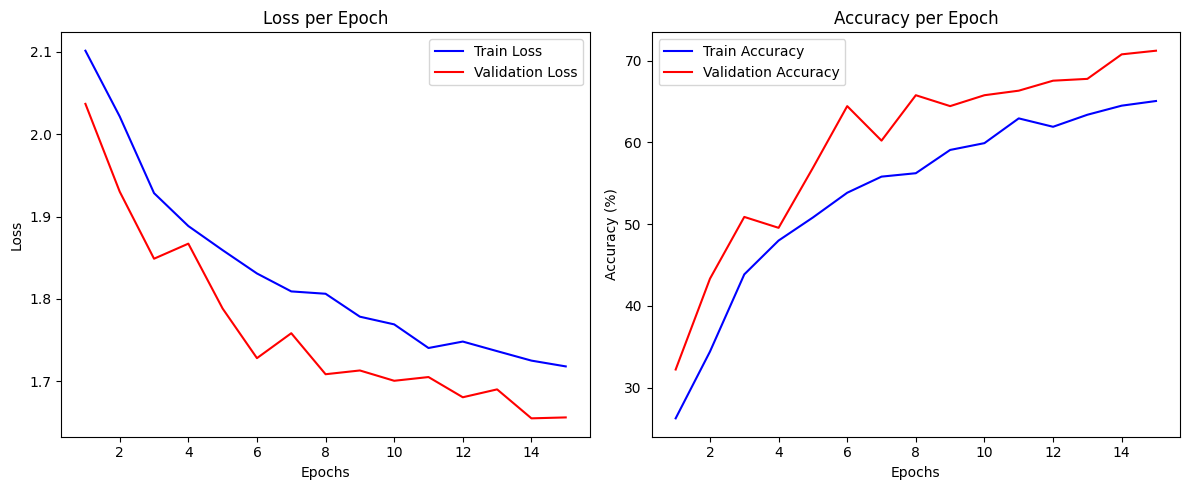

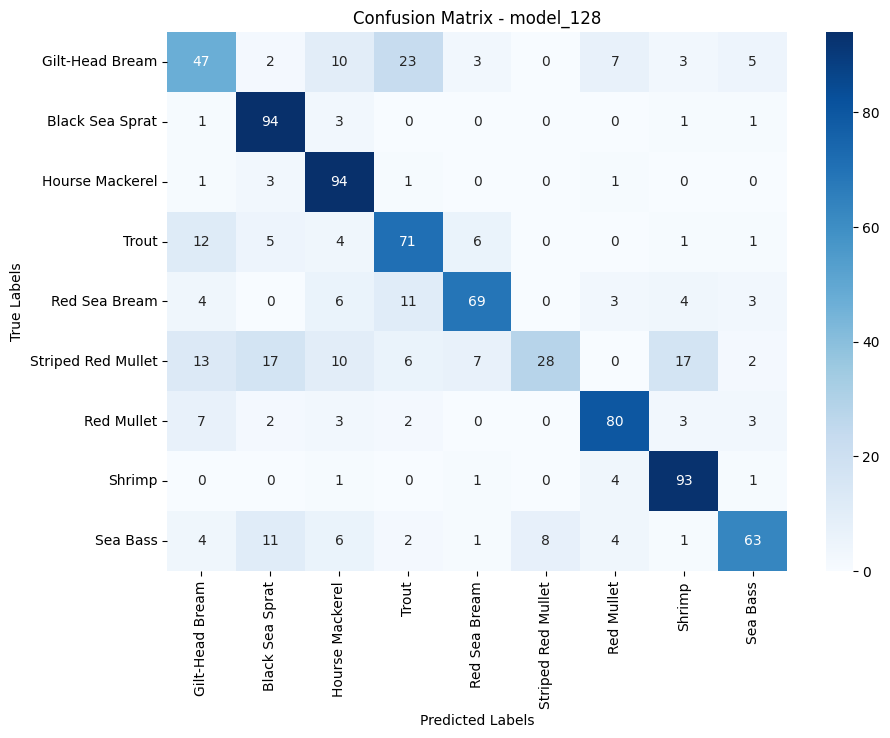

Model: model_128
Accuracy: 0.71
Recall: 0.71
Precision: 0.7178123029858751
F1-Score: 0.6936859673517428


In [27]:
model_128 = model_128.to(device)

# Kayıp fonksiyonu ve optimizer tanımlama
criterion = nn.CrossEntropyLoss()
optimizer_128 = torch.optim.Adam(model_128.parameters(), lr=0.001)

# 128 nöronlu modelin eğitim aşaması
train_loss_arr_128, train_accuracy_arr_128, val_loss_arr_128, val_accuracy_arr_128 = train_model(
    model_128, train_loader, val_loader, criterion, optimizer_128, num_epochs=epochs, device=device)

# Eğitim sonuçlarını görselleştirme
plot_training_curves(train_loss_arr_128, val_loss_arr_128, train_accuracy_arr_128, val_accuracy_arr_128)

# 128 nöronlu modelin sonuçlarını hesaplayalım
metrics("model_128", model_128, test_loader, criterion, device, label_mapping)

# 512 Katmanlı Model

In [28]:
hidden_layers = [512]  # Gizli katmanlar
dropout_rate = 0.5  # Dropout oranı

# create_model fonksiyonu ile modeli oluştur
model_512 = create_model(input_size, output_size, hidden_layers, dropout_rate)

# Modeli kontrol etmek için yapı bilgilerini yazdır
print(model_512)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=12288, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=512, out_features=9, bias=True)
  (5): Softmax(dim=1)
)


Epoch [1/15], Train Loss: 2.1392, Validation Loss: 2.1327, Validation Accuracy: 22.11%
Epoch [2/15], Train Loss: 2.1031, Validation Loss: 2.0773, Validation Accuracy: 27.78%
Epoch [3/15], Train Loss: 2.0976, Validation Loss: 2.0667, Validation Accuracy: 29.00%
Epoch [4/15], Train Loss: 2.0917, Validation Loss: 2.0767, Validation Accuracy: 28.11%
Epoch [5/15], Train Loss: 2.1090, Validation Loss: 2.0927, Validation Accuracy: 26.44%
Epoch [6/15], Train Loss: 2.0655, Validation Loss: 2.0496, Validation Accuracy: 30.89%
Epoch [7/15], Train Loss: 2.0541, Validation Loss: 2.0626, Validation Accuracy: 29.56%
Epoch [8/15], Train Loss: 2.0754, Validation Loss: 2.0343, Validation Accuracy: 32.44%
Epoch [9/15], Train Loss: 2.0773, Validation Loss: 2.0447, Validation Accuracy: 31.33%
Epoch [10/15], Train Loss: 2.0558, Validation Loss: 2.0364, Validation Accuracy: 32.11%
Epoch [11/15], Train Loss: 2.0411, Validation Loss: 2.0729, Validation Accuracy: 28.44%
Epoch [12/15], Train Loss: 2.0435, Valida

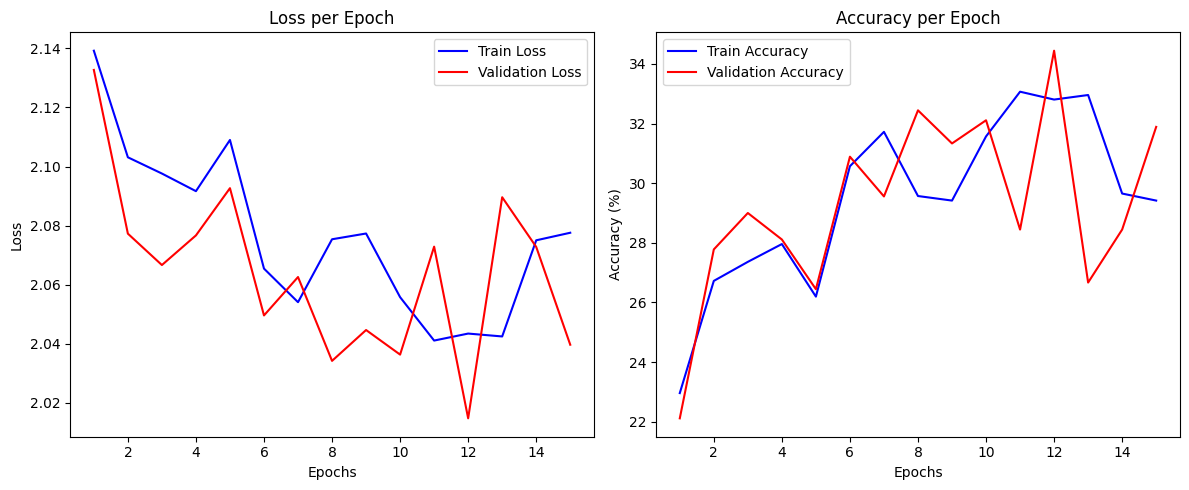

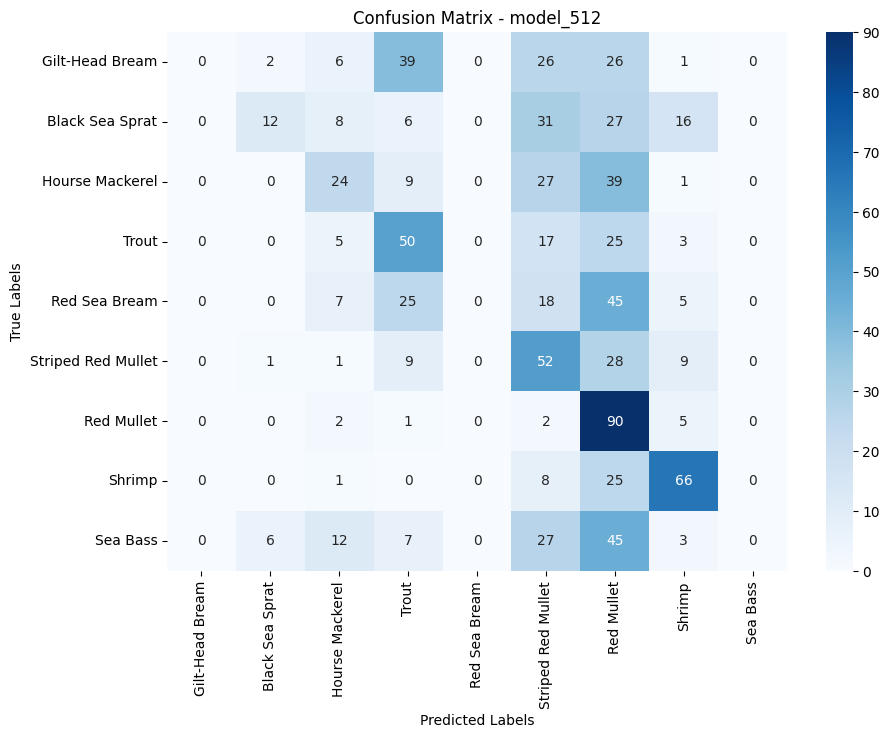

Model: model_512
Accuracy: 0.32666666666666666
Recall: 0.32666666666666666
Precision: 0.2655753480876014
F1-Score: 0.2514721204461611


In [29]:
model_512 = model_512.to(device)

# Kayıp fonksiyonu ve optimizer tanımlama
criterion = nn.CrossEntropyLoss()
optimizer_512 = torch.optim.Adam(model_512.parameters(), lr=0.001)

# 512 nöronlu modelin eğitim aşaması
train_loss_arr_512, train_accuracy_arr_512, val_loss_arr_512, val_accuracy_arr_512 = train_model(
    model_512, train_loader, val_loader, criterion, optimizer_512, num_epochs=epochs, device=device)

# Eğitim sonuçlarını görselleştirme
plot_training_curves(train_loss_arr_512, val_loss_arr_512, train_accuracy_arr_512, val_accuracy_arr_512)
metrics("model_512", model_512, test_loader, criterion, device, label_mapping)

# 0.7 Dropout Model

Epoch [1/15], Train Loss: 2.1840, Validation Loss: 2.0788, Validation Accuracy: 27.78%
Epoch [2/15], Train Loss: 2.1259, Validation Loss: 2.0742, Validation Accuracy: 28.67%
Epoch [3/15], Train Loss: 2.0979, Validation Loss: 2.0501, Validation Accuracy: 31.11%
Epoch [4/15], Train Loss: 2.0922, Validation Loss: 2.0169, Validation Accuracy: 34.67%
Epoch [5/15], Train Loss: 2.0751, Validation Loss: 2.0346, Validation Accuracy: 32.78%
Epoch [6/15], Train Loss: 2.0821, Validation Loss: 2.0353, Validation Accuracy: 32.44%
Epoch [7/15], Train Loss: 2.0666, Validation Loss: 1.9894, Validation Accuracy: 36.44%
Epoch [8/15], Train Loss: 2.0526, Validation Loss: 1.9840, Validation Accuracy: 37.22%
Epoch [9/15], Train Loss: 2.0554, Validation Loss: 1.9912, Validation Accuracy: 36.44%
Epoch [10/15], Train Loss: 2.0367, Validation Loss: 1.9811, Validation Accuracy: 37.67%
Epoch [11/15], Train Loss: 2.0393, Validation Loss: 1.9780, Validation Accuracy: 38.00%
Epoch [12/15], Train Loss: 2.0295, Valida

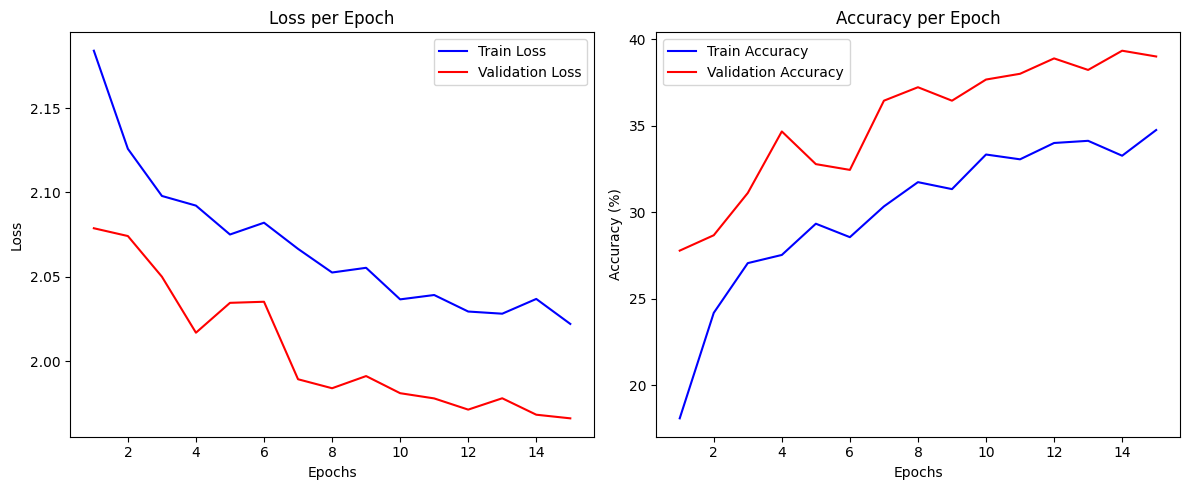

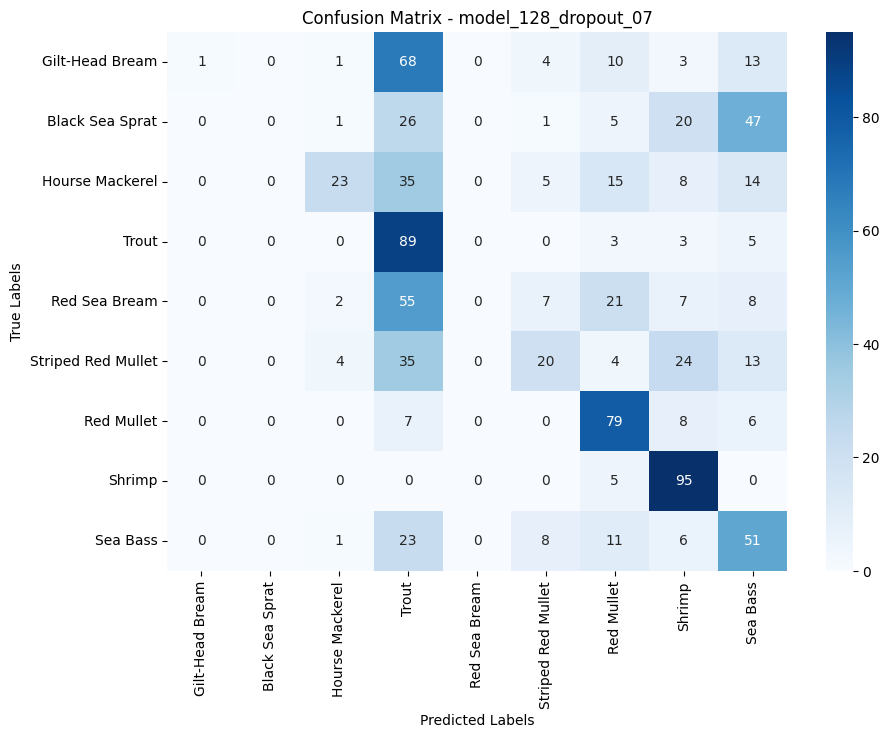

Model: model_128_dropout_07
Accuracy: 0.3977777777777778
Recall: 0.3977777777777778
Precision: 0.42374063322426764
F1-Score: 0.30726281522593873


In [30]:
# 128 Nöronlu Model (Dropout 0.7)
hidden_layers = [128]  # Gizli katmanlar
dropout_rate = 0.7  # Dropout oranı

# create_model fonksiyonu ile modeli oluştur
model_128_dropout_07 = create_model(input_size, output_size, hidden_layers, dropout_rate)

# Modeli cihaza aktar
model_128_dropout_07 = model_128_dropout_07.to(device)

# Kayıp fonksiyonu ve optimizer tanımlama
optimizer_128_dropout_07 = torch.optim.Adam(model_128_dropout_07.parameters(), lr=0.001)

# 128 nöronlu modelin eğitim aşaması (dropout 0.7)
train_loss_arr_128_07, train_accuracy_arr_128_07, val_loss_arr_128_07, val_accuracy_arr_128_07 = train_model(
    model_128_dropout_07, train_loader, val_loader, criterion, optimizer_128_dropout_07, num_epochs=epochs, device=device)

# Eğitim sonuçlarını görselleştirme
plot_training_curves(train_loss_arr_128_07, val_loss_arr_128_07, train_accuracy_arr_128_07, val_accuracy_arr_128_07)
metrics("model_128_dropout_07", model_128_dropout_07, test_loader, criterion, device, label_mapping)

# SGD Algoritmalı Model

Epoch [1/15], Train Loss: 2.0371, Validation Loss: 1.8839, Validation Accuracy: 50.67%
Epoch [2/15], Train Loss: 1.8696, Validation Loss: 1.7789, Validation Accuracy: 60.56%
Epoch [3/15], Train Loss: 1.7990, Validation Loss: 1.7530, Validation Accuracy: 61.78%
Epoch [4/15], Train Loss: 1.7661, Validation Loss: 1.7076, Validation Accuracy: 65.67%
Epoch [5/15], Train Loss: 1.7311, Validation Loss: 1.7061, Validation Accuracy: 66.33%
Epoch [6/15], Train Loss: 1.7170, Validation Loss: 1.6447, Validation Accuracy: 73.22%
Epoch [7/15], Train Loss: 1.6957, Validation Loss: 1.6432, Validation Accuracy: 72.44%
Epoch [8/15], Train Loss: 1.6877, Validation Loss: 1.6139, Validation Accuracy: 76.89%
Epoch [9/15], Train Loss: 1.6699, Validation Loss: 1.6176, Validation Accuracy: 75.00%
Epoch [10/15], Train Loss: 1.6543, Validation Loss: 1.5935, Validation Accuracy: 77.44%
Epoch [11/15], Train Loss: 1.6382, Validation Loss: 1.5742, Validation Accuracy: 79.44%
Epoch [12/15], Train Loss: 1.6290, Valida

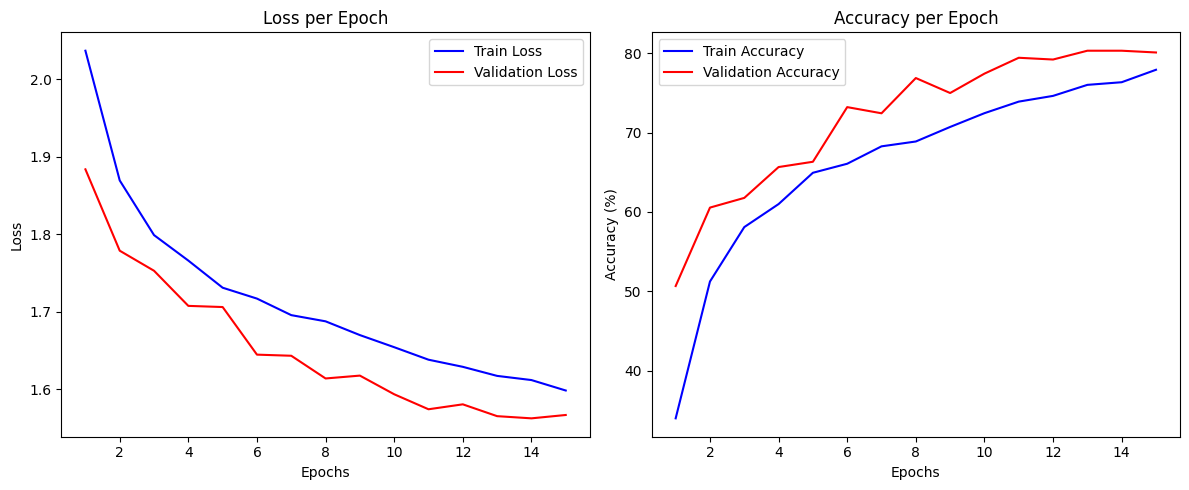

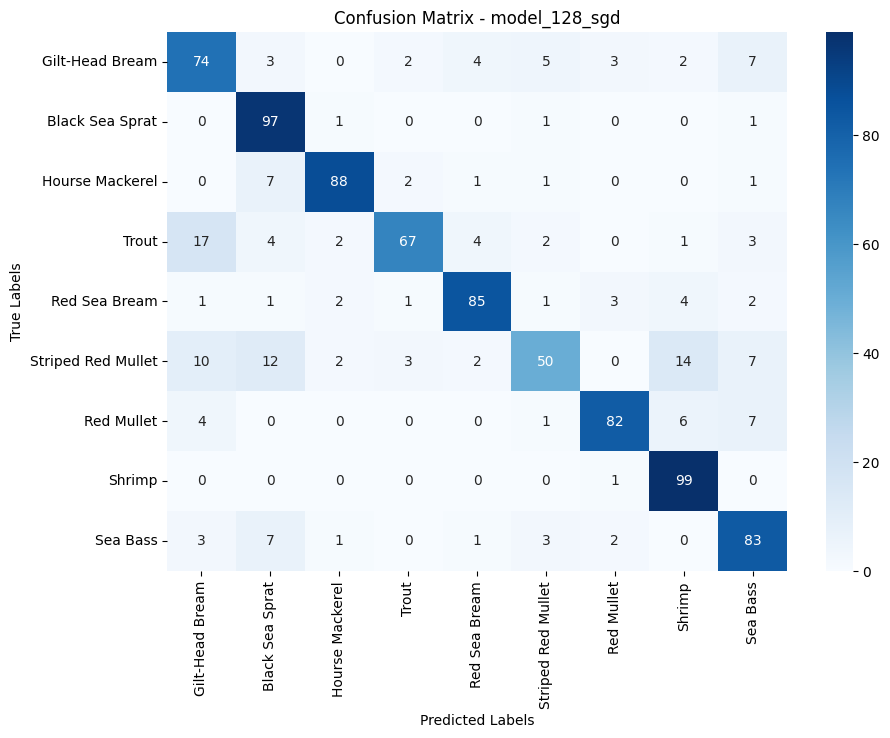

Model: model_128_sgd
Accuracy: 0.8055555555555556
Recall: 0.8055555555555556
Precision: 0.8134951880211924
F1-Score: 0.8006454818299614


In [31]:
# 128 Nöronlu SGD Model
hidden_layers = [128]  # Gizli katmanlar
dropout_rate = 0.5  # Dropout oranı

# create_model fonksiyonu ile modeli oluştur
model_128_sgd = create_model(input_size, output_size, hidden_layers, dropout_rate)

# Modeli cihaza aktar
model_128_sgd = model_128_sgd.to(device)

# Kayıp fonksiyonu ve optimizer tanımlama (SGD)
optimizer_128_sgd = torch.optim.SGD(model_128_sgd.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# 128 nöronlu modelin eğitim aşaması (SGD ile)
train_loss_arr_128_sgd, train_accuracy_arr_128_sgd, val_loss_arr_128_sgd, val_accuracy_arr_128_sgd = train_model(
    model_128_sgd, train_loader, val_loader, criterion, optimizer_128_sgd, num_epochs=epochs, device=device)

# Eğitim sonuçlarını görselleştirme
plot_training_curves(train_loss_arr_128_sgd, val_loss_arr_128_sgd, train_accuracy_arr_128_sgd, val_accuracy_arr_128_sgd)
metrics("model_128_sgd", model_128_sgd, test_loader, criterion, device, label_mapping)


# [128,512] Gizli Katmanlı Model

In [32]:
# 512 ve 128 Nöronlu Gizli Katmanlar
hidden_layers = [128, 512]  # Gizli katmanlar
dropout_rate = 0.5  # Dropout oranı

# create_model fonksiyonu ile modeli oluştur
model_512_128 = create_model(input_size, output_size, hidden_layers, dropout_rate)

# Modeli cihaza aktar
model_512_128 = model_512_128.to(device)

# Kayıp fonksiyonu ve optimizer tanımlama
criterion = nn.CrossEntropyLoss()
optimizer_512_128 = torch.optim.SGD(model_512_128.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# Modelin eğitim aşaması
train_loss_arr_512_128, train_accuracy_arr_512_128, val_loss_arr_512_128, val_accuracy_arr_512_128 = train_model(
    model_512_128, train_loader, val_loader, criterion, optimizer_512_128, num_epochs=epochs, device=device)



Epoch [1/15], Train Loss: 2.1365, Validation Loss: 2.0194, Validation Accuracy: 35.33%
Epoch [2/15], Train Loss: 1.9830, Validation Loss: 1.8763, Validation Accuracy: 48.67%
Epoch [3/15], Train Loss: 1.8906, Validation Loss: 1.8155, Validation Accuracy: 55.67%
Epoch [4/15], Train Loss: 1.8531, Validation Loss: 1.7726, Validation Accuracy: 59.44%
Epoch [5/15], Train Loss: 1.8243, Validation Loss: 1.7393, Validation Accuracy: 62.67%
Epoch [6/15], Train Loss: 1.7973, Validation Loss: 1.7278, Validation Accuracy: 64.11%
Epoch [7/15], Train Loss: 1.7797, Validation Loss: 1.6922, Validation Accuracy: 68.22%
Epoch [8/15], Train Loss: 1.7620, Validation Loss: 1.7321, Validation Accuracy: 63.22%
Epoch [9/15], Train Loss: 1.7583, Validation Loss: 1.6811, Validation Accuracy: 68.00%
Epoch [10/15], Train Loss: 1.7386, Validation Loss: 1.6759, Validation Accuracy: 69.33%
Epoch [11/15], Train Loss: 1.7392, Validation Loss: 1.6703, Validation Accuracy: 70.44%
Epoch [12/15], Train Loss: 1.7281, Valida

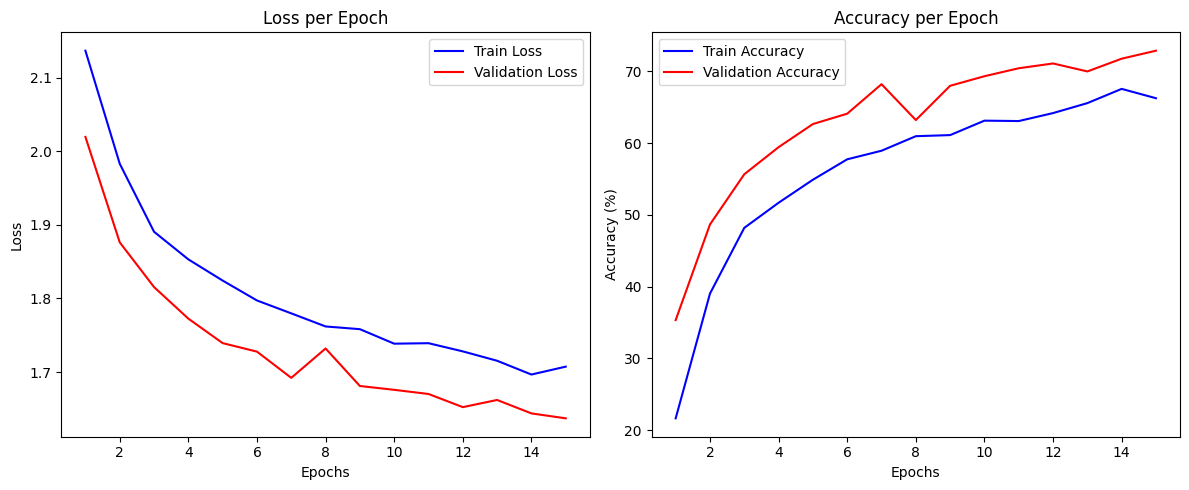

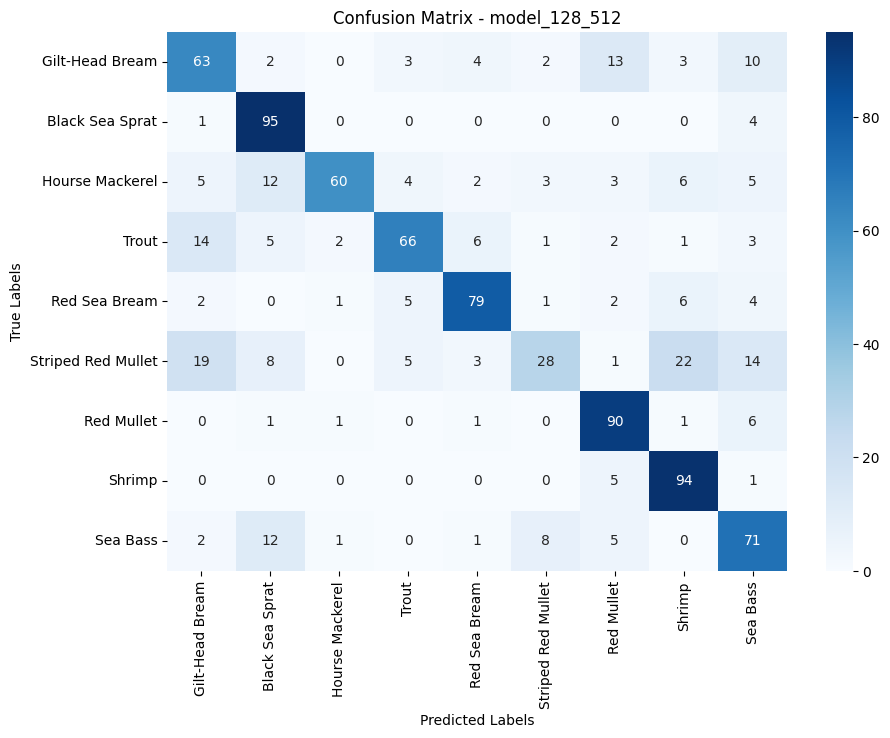

Model: model_128_512
Accuracy: 0.7177777777777777
Recall: 0.7177777777777777
Precision: 0.7269604350131195
F1-Score: 0.7043554338436725


In [33]:
# Eğitim sonuçlarını görselleştirme
plot_training_curves(train_loss_arr_512_128, val_loss_arr_512_128, train_accuracy_arr_512_128, val_accuracy_arr_512_128)
metrics("model_128_512", model_512_128, test_loader, criterion, device, label_mapping)

# Model Sonuçları

In [34]:
all_result

,Model,Accuracy,Recall,Precision,F1-Score
0,model_128,0.710000,0.710000,0.717812,0.693686
1,model_512,0.326667,0.326667,0.265575,0.251472
2,model_128_dropout_07,0.397778,0.397778,0.423741,0.307263
3,model_128_sgd,0.805556,0.805556,0.813495,0.800645
4,model_128_512,0.717778,0.717778,0.726960,0.704355
